# Fit XGBoost model for multiple time slices as input

In this experiment we will use multiple time slices as an input for our XGBoost model and evaluate the performance.

In [95]:
import pandas as pd
import seaborn as sns
import shap
from matplotlib import pyplot as plt
import monipy.utils.database as database
from sklearn.model_selection import train_test_split, GridSearchCV
from xgboost import XGBClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, recall_score
from sklearn.inspection import permutation_importance
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

### 1. Helping Functions

In [96]:
def load_and_prep_data(window=0, data_filter=4):
    # load data
    df = pd.concat([pd.read_csv(f"data/useable_yes_unknown/filter_{data_filter}/sandor_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/ukt_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/freiburg_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/uka_corvolution_full.csv", index_col=[0]),
              pd.read_csv(f"data/useable_yes/filter_{data_filter}/uka_klinik_full.csv", index_col=[0]),
             ])
    
    # rename column
    df = df.rename(columns={"window_Unnamed: 2093_level_1": "window"})
    
    # filter for one starting window
    df = df[df["window"] == window]
    
    # get patient specific columns
    df_patients_columns = database.get_all_patients().columns
    
    # drop patient specific columns and other columns
    df = df.drop(columns = list(df_patients_columns))

    columns = ["seizure_id_Unnamed: 2091_level_1", 
           "record_id", "window", 
           "timestamp_start_Unnamed: 2094_level_1"]
    df = df.drop(columns=columns)

    return df

In [97]:
def train_test_val_split(df):
    # split the data val, test, train
    val_patients = pd.read_csv("data/patients/val_patients_1.csv", index_col=[0]).reset_index(drop=True)
    test_patients = pd.read_csv("data/patients/test_patients_1.csv", index_col=[0]).reset_index(drop=True)
    
    df_val = df[df["patient_id"].isin(val_patients.iloc[:, 0])].reset_index(drop=True)
    df_test = df[df["patient_id"].isin(test_patients.iloc[:, 0])].reset_index(drop=True)
    df_train = df[~(df["patient_id"].isin(set(val_patients.iloc[:, 0]) | set(test_patients.iloc[:, 0])))].reset_index(drop=True)
    return df_val, df_test, df_train

In [98]:
def create_splits(df_train, df_test, df_val, features, time_slice=0):
    data_split = {}
    for split in ["val", "test", "train"]:
        data_split[f"X_{split}"] = eval(f"df_{split}")[[f"{feature}_{time_slice}" for feature in features]]
        data_split[f"y_{split}"] = eval(f"df_{split}")[["seizure"]]
    return data_split["X_train"], data_split["y_train"], data_split["X_test"], data_split["y_test"], data_split["X_val"], data_split["y_val"]

In [99]:
# fit xgboost model
def fit_and_eval(X_train, y_train, X_test, y_test):
    # Define initial hyperparameters
    params = {
        'objective': 'binary:logistic',  # Binary classification objective
        'learning_rate': 0.1,  # Learning rate
        'max_depth': 7, # Maximum depth of each tree
        'n_estimators': 300,
        'subsample': 0.8,  # Subsample ratio of the training instances
        'colsample_bytree': 0.8,  # Subsample ratio of features when constructing each tree
        'scale_pos_weight': 0.9,
    }

    # Create the XGBoost classifier
    model = XGBClassifier(**params)

    # Train the XGBoost model
    model.fit(X_train, y_train)

    # Predict on the test set
    y_pred = model.predict(X_test)

    # return evaluation
    return model, (accuracy_score(y_test, y_pred), confusion_matrix(y_test, y_pred), classification_report(y_test, y_pred),recall_score(y_test, y_pred),recall_score(y_test, y_pred, pos_label=0))

In [100]:
features = {'avg',
 'csi',
 'csi_filtered',
 'csi_filtered_slope',
 'csi_slope',
 'csim',
 'csim_filtered',
 'csim_filtered_slope',
 'csim_slope',
 'cvi',
 'hf',
 'hr_diff',
 'hr_diff_filtered',
 'hr_diff_filtered_slope',
 'hr_diff_slope',
 'kurt',
 'lf',
 'lf_hf_ratio',
 'mf_coef_center',
 'mf_coef_left',
 'mf_coef_right',
 'mf_hurst_max',
 'nnx',
 'pnnx',
 'quantile_25',
 'quantile_50',
 'quantile_75',
 'rmssd',
 'rmssd_dt',
 'sd',
 'sd1',
 'sd2',
 'skew',
 'total_power',
 'triangular_index',
 'ulf',
 'variance',
 'vlf'}

### 2. Load Data

In [101]:
df = load_and_prep_data()
print(df.shape)
df_val, df_test, df_train = train_test_val_split(df)

[creating new connection]
(3320, 2092)


### 3. Test Performance for different time slices

In [102]:
performance = []
for time_slices in range(1,55,1):   
    x = []
    for i in range(0,time_slices,1):
        x = x + [f"{feature}_{i}" for feature in features]
       
    X_train = df_train[x]
    y_train = df_train.seizure

    X_test = df_test[x]
    y_test = df_test.seizure

    X_val = df_val[x]
    y_val = df_val.seizure

    
    model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train, X_test, y_test)
    
    performance.append(
        {
        "time_slices": time_slices,
        "accuracy": accuracy,
        "confusion_matrix": cm,
        "report": cr,
        "recall_1": recall_1,
        "recall_0": recall_0
        }
    )

In [103]:
df_performance = pd.DataFrame(performance)

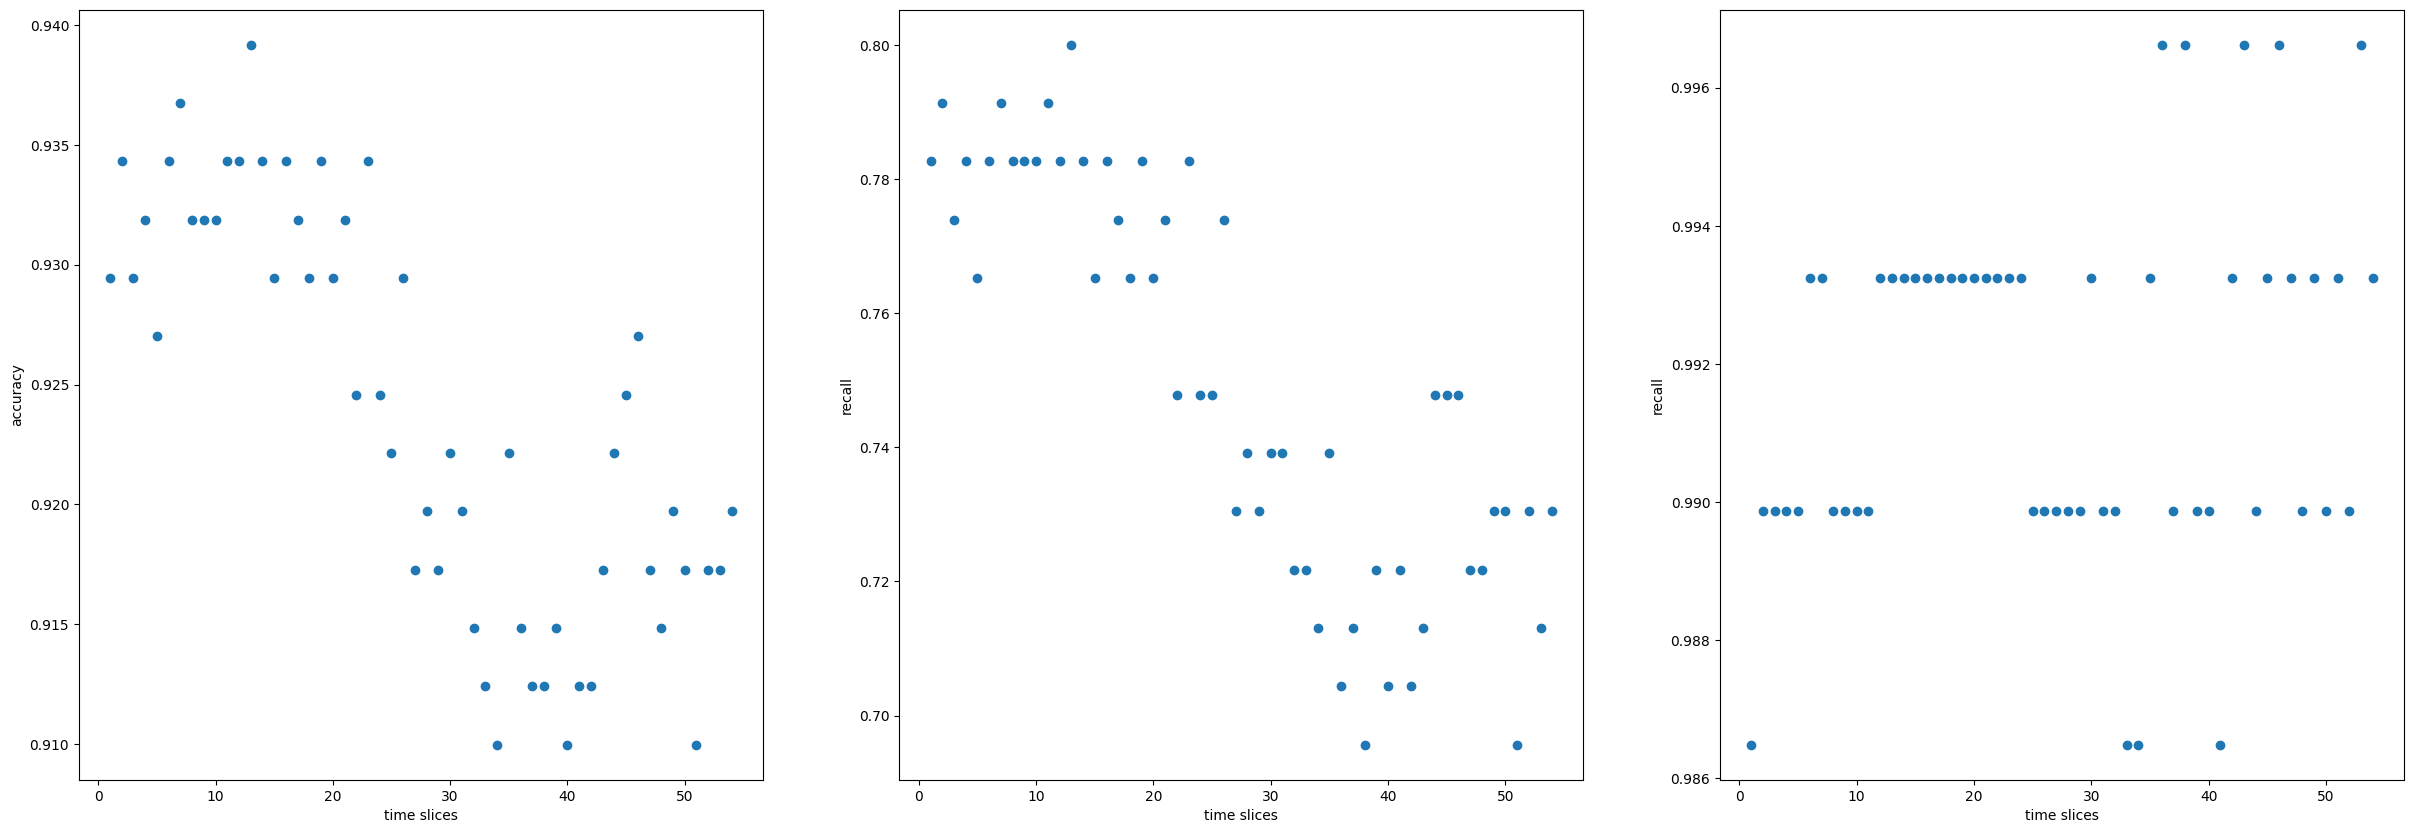

In [104]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=1, ncols=3, figsize=(30,10))

ax1.scatter(df_performance["time_slices"], df_performance["accuracy"])
ax1.set_xlabel("time slices")
ax1.set_ylabel("accuracy")

ax2.scatter(df_performance["time_slices"], df_performance["recall_1"])
ax2.set_xlabel("time slices")
ax2.set_ylabel("recall")

ax3.scatter(df_performance["time_slices"], df_performance["recall_0"])
ax3.set_xlabel("time slices")
ax3.set_ylabel("recall")

fig.savefig("time_slices_eval.png")

In [105]:
df_performance.sort_values(by="accuracy", ascending=False).head(10)

,time_slices,accuracy,confusion_matrix,report,recall_1,recall_0
12,13,0.939173,"[[294, 2], [23, 92]]",precision recall f1-score ...,0.800000,0.993243
6,7,0.936740,"[[294, 2], [24, 91]]",precision recall f1-score ...,0.791304,0.993243
1,2,0.934307,"[[293, 3], [24, 91]]",precision recall f1-score ...,0.791304,0.989865
15,16,0.934307,"[[294, 2], [25, 90]]",precision recall f1-score ...,0.782609,0.993243
5,6,0.934307,"[[294, 2], [25, 90]]",precision recall f1-score ...,0.782609,0.993243
22,23,0.934307,"[[294, 2], [25, 90]]",precision recall f1-score ...,0.782609,0.993243
13,14,0.934307,"[[294, 2], [25, 90]]",precision recall f1-score ...,0.782609,0.993243
18,19,0.934307,"[[294, 2], [25, 90]]",precision recall f1-score ...,0.782609,0.993243
10,11,0.934307,"[[293, 3], [24, 91]]",precision recall f1-score ...,0.791304,0.989865
11,12,0.934307,"[[294, 2], [25, 90]]",precision recall f1-score ...,0.782609,0.993243


In [106]:
df_performance.sort_values(by="recall_1", ascending=False).head(10)

,time_slices,accuracy,confusion_matrix,report,recall_1,recall_0
12,13,0.939173,"[[294, 2], [23, 92]]",precision recall f1-score ...,0.800000,0.993243
10,11,0.934307,"[[293, 3], [24, 91]]",precision recall f1-score ...,0.791304,0.989865
1,2,0.934307,"[[293, 3], [24, 91]]",precision recall f1-score ...,0.791304,0.989865
6,7,0.936740,"[[294, 2], [24, 91]]",precision recall f1-score ...,0.791304,0.993243
0,1,0.929440,"[[292, 4], [25, 90]]",precision recall f1-score ...,0.782609,0.986486
22,23,0.934307,"[[294, 2], [25, 90]]",precision recall f1-score ...,0.782609,0.993243
18,19,0.934307,"[[294, 2], [25, 90]]",precision recall f1-score ...,0.782609,0.993243
13,14,0.934307,"[[294, 2], [25, 90]]",precision recall f1-score ...,0.782609,0.993243
11,12,0.934307,"[[294, 2], [25, 90]]",precision recall f1-score ...,0.782609,0.993243
15,16,0.934307,"[[294, 2], [25, 90]]",precision recall f1-score ...,0.782609,0.993243


In [107]:
df_performance.sort_values(by="recall_0", ascending=False).head(10)

,time_slices,accuracy,confusion_matrix,report,recall_1,recall_0
52,53,0.917275,"[[295, 1], [33, 82]]",precision recall f1-score ...,0.713043,0.996622
37,38,0.912409,"[[295, 1], [35, 80]]",precision recall f1-score ...,0.695652,0.996622
42,43,0.917275,"[[295, 1], [33, 82]]",precision recall f1-score ...,0.713043,0.996622
45,46,0.927007,"[[295, 1], [29, 86]]",precision recall f1-score ...,0.747826,0.996622
35,36,0.914842,"[[295, 1], [34, 81]]",precision recall f1-score ...,0.704348,0.996622
53,54,0.919708,"[[294, 2], [31, 84]]",precision recall f1-score ...,0.730435,0.993243
16,17,0.931873,"[[294, 2], [26, 89]]",precision recall f1-score ...,0.773913,0.993243
29,30,0.922141,"[[294, 2], [30, 85]]",precision recall f1-score ...,0.739130,0.993243
41,42,0.912409,"[[294, 2], [34, 81]]",precision recall f1-score ...,0.704348,0.993243
44,45,0.924574,"[[294, 2], [29, 86]]",precision recall f1-score ...,0.747826,0.993243


### 4. Consider the first 13 time slices

In [108]:
x = []
for i in range(0,14,1):
    x = x + [f"{feature}_{i}" for feature in features]

In [109]:
X_train = df_train[x]
y_train = df_train.seizure

X_test = df_test[x]
y_test = df_test.seizure

X_val = df_val[x]
y_val = df_val.seizure

In [110]:
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train, X_test, y_test)

In [111]:
print(cr)

              precision    recall  f1-score   support

           0       0.92      0.99      0.96       296
           1       0.98      0.78      0.87       115

    accuracy                           0.93       411
   macro avg       0.95      0.89      0.91       411
weighted avg       0.94      0.93      0.93       411



In [112]:
print(cm)

[[294   2]
 [ 25  90]]


In [113]:
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), X_val, y_val)

In [114]:
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.98      0.96       426
           1       0.88      0.67      0.76        83

    accuracy                           0.93       509
   macro avg       0.91      0.83      0.86       509
weighted avg       0.93      0.93      0.93       509



In [115]:
scaler = StandardScaler()
X_train_norm = scaler.fit_transform(X_train)

scaler = StandardScaler()
X_test_norm = scaler.fit_transform(X_test)

scaler = StandardScaler()
X_val_norm = scaler.fit_transform(X_val)

In [116]:
pca = PCA(n_components=10)
pca.fit(X_train_norm)
pca_train = pca.transform(X_train_norm)
pca_train_df = pd.DataFrame(pca_train)

In [117]:
pca = PCA(n_components=10)
pca.fit(X_test_norm)
pca_test = pca.transform(X_test_norm)
pca_test_df = pd.DataFrame(pca_test)

In [118]:
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(pca_train, y_train, pca_test, y_test)

In [119]:
print(cr)

              precision    recall  f1-score   support

           0       0.72      0.93      0.81       296
           1       0.24      0.06      0.10       115

    accuracy                           0.68       411
   macro avg       0.48      0.49      0.45       411
weighted avg       0.58      0.68      0.61       411



In [120]:
print(cm)

[[274  22]
 [108   7]]


### 5. Consider time slices before onset

In [121]:
df = load_and_prep_data(window=-18)
print(df.shape)
df_val, df_test, df_train = train_test_val_split(df)

[creating new connection]
(3320, 2092)


In [122]:
x = []
for i in range(14,29,1):
    x = x + [f"{feature}_{i}" for feature in features]

In [123]:
X_train = df_train[x]
y_train = df_train.seizure

X_test = df_test[x]
y_test = df_test.seizure

X_val = df_val[x]
y_val = df_val.seizure

In [124]:
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train, X_test, y_test)

In [125]:
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.99      0.97       296
           1       0.98      0.83      0.90       115

    accuracy                           0.95       411
   macro avg       0.96      0.91      0.93       411
weighted avg       0.95      0.95      0.95       411



In [126]:
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(pd.concat([X_train, X_test]), pd.concat([y_train, y_test]), X_val, y_val)

In [127]:
print(cr)

              precision    recall  f1-score   support

           0       0.94      0.99      0.96       426
           1       0.92      0.67      0.78        83

    accuracy                           0.94       509
   macro avg       0.93      0.83      0.87       509
weighted avg       0.94      0.94      0.93       509



In [128]:
model, (accuracy, cm, cr, recall_1, recall_0) = fit_and_eval(X_train, y_train , X_val, y_val)

In [129]:
print(cr)

              precision    recall  f1-score   support

           0       0.93      0.99      0.96       426
           1       0.93      0.63      0.75        83

    accuracy                           0.93       509
   macro avg       0.93      0.81      0.85       509
weighted avg       0.93      0.93      0.93       509

